# Exploratory data analysis

## Load the dataset

In [1]:
import json

from functools import reduce
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import altair as alt
from collections import Counter

import os.path
import numpy as np
import re
import pandas as pd

import gensim 
from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet

import gensim.corpora as corpora
from gensim.corpora import Dictionary

from gensim import matutils, models

import pyLDAvis.gensim
import string
pd.set_option('display.max_colwidth', 100)
%matplotlib inline

In [2]:
set_names = ['rsicd', 'ucm']

def get_img_info(name):
    """
    Returns img paths and captions

    Parameters:
    -----------
    name: str
        the json file name
    
    Return:
    --------
    list, list
        img paths, corresponding captions
    """
    img_path = []
    caption = [] 
    caption_token = []
    with open('../data/interim/' + name + '.json', 'r') as json_data:
        data = json.load(json_data)
        for set_name in set_names:
            for filename in data[set_name].keys():
                img_path.append('../data/raw/imgs/'+ set_name + '/' + filename)
                caption.append([sentence['raw'] for sentence in data[set_name][filename]['sentences']])
                caption_token.append([sentence['tokens'] for sentence in data[set_name][filename]['sentences']])
    
    return img_path, caption, caption_token

In [3]:
# get img path and caption list
train_img_path, train_caption, train_caption_token = get_img_info('train')
valid_img_path, valid_caption, valid_caption_token = get_img_info('valid')

In [9]:
len(train_caption)

8332

In [10]:
len(valid_caption)

2084

In [11]:
train_img_path[:10]

['../data/raw/imgs/rsicd/denseresidential_363.jpg',
 '../data/raw/imgs/rsicd/resort_126.jpg',
 '../data/raw/imgs/rsicd/baseballfield_165.jpg',
 '../data/raw/imgs/rsicd/forest_163.jpg',
 '../data/raw/imgs/rsicd/square_323.jpg',
 '../data/raw/imgs/rsicd/storagetanks_14.jpg',
 '../data/raw/imgs/rsicd/parking_301.jpg',
 '../data/raw/imgs/rsicd/school_264.jpg',
 '../data/raw/imgs/rsicd/bareland_87.jpg',
 '../data/raw/imgs/rsicd/denseresidential_179.jpg']

In [12]:
train_caption[:10]

[['the area is a densely populated area .',
  'many green plants are planted around the neighborhood .',
  'many green plants are planted around the neighborhood .',
  'the area is a densely populated area .',
  'the area is a densely populated area .'],
 ['many green trees and several buildings with swimming pools are near a beach in a resort .',
  'many green trees and several buildings with swimming pools are near a beach in a resort .',
  'many green trees and several buildings with swimming pools are near a beach in a resort .',
  'many green trees and several buildings with swimming pools are near a beach in a resort .',
  'many green trees and several buildings with swimming pools are near a beach in a resort .'],
 ['the fan shaped baseball field has a khaki circular infield .',
  'there is a lawn with a baseball field built on it on both side of which are parking lot with cars.',
  'a fanshaped baseball field with a yellow circle sand .',
  'several trees is located at corners 

## Explore the dataset

### 1. find max/min length

In [37]:
max_len = 0
min_len = len(train_caption_token[0][0])

for t in train_caption_token:
    for i in t:
        if len(i) > max_len:
            max_len = len(i)
        if len(i) < min_len and len(i) > 1:
            min_len = len(i)
        if len(i) == 1:
            print("The caption with length as 1: ", i, "\n")
            
print("The maximum length of training set is", max_len, "\n")
print("The minimum length of training set is", min_len, "\n")

The caption with length as 1:  ['1'] 

The caption with length as 1:  ['1'] 

The maximum length of training set is 34 

The minimum length of training set is 2 



> Note: We found that there are 2 captions with only "1", which is meaningless, we will remove this kind of caption in data preprocssing stage.

### 2. find most common words

In [38]:
# 2. find most common words
# original version
flattened1 = [val for sublist in train_caption_token for val in sublist]
flattened = [val.lower() for sublist in flattened1 for val in sublist]

# without stopwords version
stopwords = set(STOPWORDS) 
flattened1_wo_stop = flattened1.copy()
flattened1_wo_stop[:] = [[word for word in sub if word not in stopwords] for sub in flattened1_wo_stop]
flattened_wo_stop = [word for word  in flattened if word not in stopwords]

In [39]:
c = Counter(item for item in flattened)
c_wo_stop = Counter(item for item in flattened_wo_stop)
print(c.most_common(10))
print(c_wo_stop.most_common(10))

[('a', 36199), ('are', 20904), ('the', 17078), ('green', 16285), ('in', 15227), ('and', 14923), ('many', 14674), ('of', 13827), ('trees', 13472), ('is', 13470)]
[('green', 16285), ('many', 14674), ('trees', 13472), ('buildings', 11060), ('near', 7408), ('two', 5598), ('area', 4773), ('several', 4476), ('piece', 3908), ('road', 3902)]


In [40]:
# wordcloud
comment_words= ""
comment_words += " ".join(flattened)

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                collocations = False).generate_from_frequencies(c) 


comment_words_wo_stopwords = ""
comment_words_wo_stopwords += " ".join(flattened_wo_stop)

wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                collocations = False).generate_from_frequencies(c_wo_stop) 

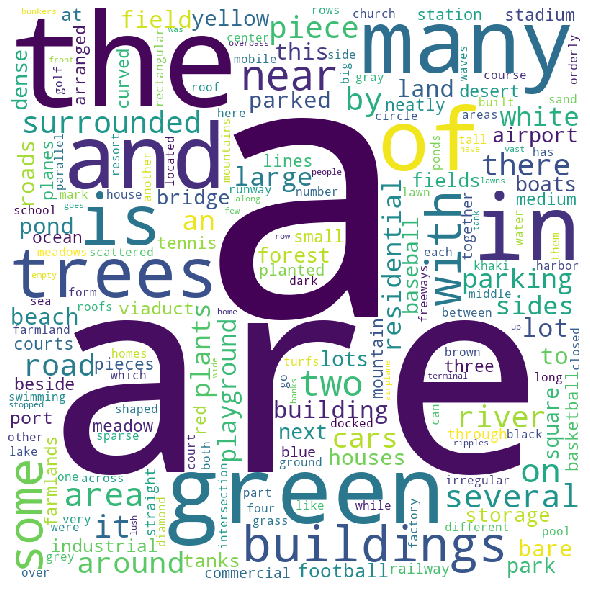

In [41]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

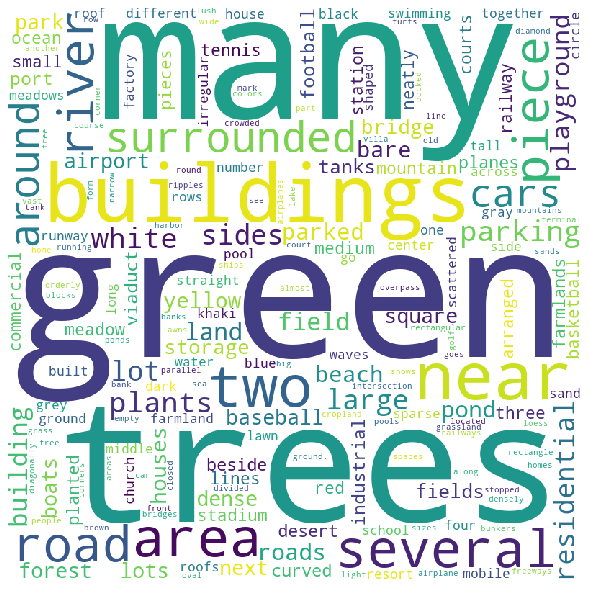

In [42]:
# plot the WordCloud image for non-stopwords version                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### 3. topic modelling



In [43]:
# get the list of nouns
from nltk.corpus import wordnet as wn
nouns = {x.name().split('.', 1)[0] for x in wn.all_synsets('n')}

In [44]:
# keep only nouns
flattern1_noun = [[word for word in sub if word in nouns] for sub in flattened1_wo_stop]

In [48]:
# create a dictionary
dictionary = corpora.Dictionary(flattern1_noun)

# create document-term co-occurrence matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in flattern1_noun]

In [49]:
# lda model configuration
lda = models.LdaModel(corpus=doc_term_matrix, 
                      id2word=dictionary, 
                      num_topics=5, 
                      passes=10)

In [50]:
lda.print_topics(num_words=4)

[(0, '0.133*"piece" + 0.126*"green" + 0.077*"forest" + 0.057*"ground"'),
 (1, '0.134*"two" + 0.115*"river" + 0.113*"roads" + 0.067*"green"'),
 (2, '0.096*"road" + 0.076*"storage" + 0.065*"building" + 0.063*"green"'),
 (3, '0.124*"green" + 0.081*"go" + 0.066*"runway" + 0.060*"field"'),
 (4, '0.119*"area" + 0.115*"white" + 0.097*"parking" + 0.083*"lot"')]

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.120859  0.248529       1        1  18.971184
1     -0.292344  0.141679       2        1  22.457191
2      0.107093 -0.291109       3        1  19.004831
3      0.251655  0.054681       4        1  18.737968
4     -0.187262 -0.153780       5        1  20.828821, topic_info=         Term         Freq        Total Category  logprob  loglift
20      piece  3292.000000  3292.000000  Default  30.0000  30.0000
67      river  3362.000000  3362.000000  Default  29.0000  29.0000
70      roads  3310.000000  3310.000000  Default  28.0000  28.0000
60        two  4594.000000  4594.000000  Default  27.0000  27.0000
26      white  3119.000000  3119.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
28       road   754.481018  4431.924805   Topic5  -3.5815  -0.2017
17     yellow   282.902893  1055.698242   Topic5  -4.5625   0.2520
140    people    97.668755   154.251877   Topic5  -5.6260   1.1118
73     center   113.366013   328.601746   Topic5  -5.4769   0.5046
111  terminal    84.219193   121.202438   Topic5  -5.7741   1.2048

[224 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
626       3  0.998838  airplane
104       5  0.999455   airport
241       5  0.986741       arc
0         2  0.332673      area
0         5  0.667209      area
...     ...       ...       ...
773       1  0.994047     weeds
26        5  0.999820     white
344       1  0.986131      wild
17        1  0.731270    yellow
17        5  0.268069    yellow

[205 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [68]:
topic_labels = {0:'Forest',
               1: 'River',
               2: 'Road',
               3: 'Natrual',
               4: 'Parking & Transpotation'}
topic_labels

{0: 'Forest',
 1: 'River',
 2: 'Road',
 3: 'Natrual',
 4: 'Parking & Transpotation'}

In [53]:
# lda model configuration
lda1 = models.LdaModel(corpus=doc_term_matrix, 
                      id2word=dictionary, 
                      num_topics=10, 
                      passes=10)

In [54]:
lda1.print_topics(num_words=4)

[(0, '0.254*"large" + 0.130*"farmland" + 0.130*"piece" + 0.065*"church"'),
 (1, '0.164*"piece" + 0.156*"beach" + 0.116*"green" + 0.111*"white"'),
 (2, '0.161*"green" + 0.152*"forest" + 0.084*"course" + 0.084*"golf"'),
 (3, '0.228*"parking" + 0.195*"lot" + 0.184*"river" + 0.095*"green"'),
 (4, '0.118*"straight" + 0.115*"green" + 0.113*"mobile" + 0.101*"park"'),
 (5, '0.338*"two" + 0.110*"green" + 0.092*"tennis" + 0.070*"river"'),
 (6, '0.215*"roads" + 0.088*"ground" + 0.080*"grey" + 0.064*"intersection"'),
 (7, '0.285*"road" + 0.113*"airport" + 0.098*"runway" + 0.078*"sand"'),
 (8, '0.143*"storage" + 0.123*"building" + 0.111*"baseball" + 0.083*"green"'),
 (9, '0.382*"area" + 0.123*"go" + 0.103*"green" + 0.092*"medium"')]

> After experimenting with several lda model, 5 topics makes more sense. Let's test on some validation captions

In [69]:
def get_most_prob_topic(unseen_document, model = lda):
    """
    Given an unseen_document, and a trained LDA model, this function
    finds the most likely topic (topic with the highest probability) from the 
    topic distribution of the unseen document and returns the best topic with 
    its probability.
    
    Parameters
    ------------
    unseen_document : (str) 
        the document to be labeled with a topic
    model : (gensim ldamodel) 
        the trained LDA model
    
    Returns: 
    -------------
        (str) a string of the form 
        `most likely topic label:probability of that label` 
    
    Examples:
    ----------
    >> get_most_prob_topic("The research uses an HMM for discovering gene sequence.", 
                            model = lda)
    Science and Technology:0.435
    """    
    corpus_test = unseen_document.split()
    bow_vector = dictionary.doc2bow(corpus_test)
    topic_assign = lda[bow_vector]
    topic_assign.sort(key=lambda tup: tup[1], reverse = True)
    
    most_likely = topic_assign[0]
    topic_idx = most_likely[0]
    msg = topic_labels[topic_idx] + ':' + str(most_likely[1])
    
    return msg

In [71]:
df = pd.DataFrame(valid_caption, columns = ["Caption_1", "Caption_2", "Caption_3", "Caption_4", "Caption_5"])
df['predicted_topic'] = df['Caption_1'].apply(get_most_prob_topic)
df[:10]

,Caption_1,Caption_2,Caption_3,Caption_4,Caption_5,predicted_topic
0,the lake is surrounded by many thick trees .,the resident areas besides the dark green trees .,a park with many green trees and several ponds is between a river and some buildings .,a park with many green trees and several ponds is between a river and some buildings .,the lake is surrounded by many thick trees .,Natrual:0.5999948
1,it is a piece of yellow mountain .,it is a piece of yellow mountain .,it is a piece of yellow mountain .,it is a piece of yellow mountain .,it is a piece of yellow mountain .,Forest:0.5497561
2,the residential of grey roof buildings is compactly laid out as a whole .,the residential of grey roof buildings is compactly laid out as a whole .,an arterial road separates the residential which has many trees surrounded .,rows of densely arranged houses are separated by a wide bustling road,many buildings and green trees are in two sides of a road in a dense residential area .,Road:0.5509438
3,the road through the brown fields and gray building .,in the middle of the picture is a building and a sparse lawn .,a building near a parking lot and three baseball fields is in a school .,a building near a parking lot and three baseball fields is in a school .,the road through the brown fields and gray building .,Road:0.69664526
4,many buildings are in an industrial area .,many buildings are in an industrial area .,many buildings are in an industrial area .,many buildings are in an industrial area .,many buildings are in an industrial area .,Parking & Transpotation:0.59828097
5,the playground with orange and bright green is next to a a blue building.,many buildings and some green trees are around a playground .,a playground is surrounded by many buildings and some plants .,a playground is surrounded by many green trees and many buildings .,a playground is surrounded by many buildings and some plants .,Forest:0.3955939
6,many buildings are in a commercial area .,many buildings are in a commercial area .,many buildings are in a commercial area .,many buildings are in a commercial area .,many buildings are in a commercial area .,River:0.7306775
7,long grass speared out buds .,a piece of shrubs near the pasture .,several green trees are near a piece of green meadow .,several green trees are near a piece of green meadow .,long grass speared out buds .,River:0.59856683
8,there is a huge lake on the land .,there is a bare road around the lake .,there is a bare road around the lake .,there is a huge lake on the land .,there is a huge lake on the land .,Natrual:0.3999863
9,the church is surrounded by dark green trees .,many cars packed at the gate of the church .,many green trees are around a church .,many green trees are around a church .,the church is surrounded by dark green trees .,Forest:0.7988108


### 4. Check images with 5 duplicate captions

In [72]:
# check the length of captions
count_duplicate_captions = 0
for l in train_caption:
    if l.count(l[0]) == len(l):
        count_duplicate_captions += 1
print("Number of images with 5 duplicate captions:", count_duplicate_captions)
print("Ratio of images with 5 duplicate captions:", count_duplicate_captions/len(train_caption))

Number of images with 5 duplicate captions: 3116
Ratio of images with 5 duplicate captions: 0.3739798367738838


In [73]:
# check the length of captions
count_duplicate_captions = []
for l in train_caption:
    c = Counter(l)
    count_duplicate_captions.append(len(c.items()))

df_cap = pd.DataFrame(Counter(count_duplicate_captions).items(),
            columns = ['number of unique captions per image', 'number of images'])
alt.Chart(df_cap, title = "Number of unique captions").mark_bar().encode(
    alt.Y("number of unique captions per image:O"),
    alt.X("number of images:Q"),
)

alt.Chart(...)

### 5. Top 50 most common/least common words

In [74]:
# distribution of top 50 words
top_50_wo_stop = pd.DataFrame(c_wo_stop.most_common(50), columns = ['word', 'frequency']).sort_values(by = 'frequency').reset_index()

In [75]:
alt.Chart(top_50_wo_stop, title = "Top 50 words").mark_bar().encode(
    alt.X("word:N", sort='-y'),
    alt.Y("frequency:Q"),
)

alt.Chart(...)

In [76]:
# distribution of top 50 least common words
least_50_wo_stop = pd.DataFrame(c_wo_stop.most_common()[:-51:-1], columns = ['word', 'frequency']).sort_values(by = 'frequency').reset_index()

In [77]:
alt.Chart(least_50_wo_stop, title = "Top 50 least common words").mark_bar().encode(
    alt.X("word:N", sort='-y'),
    alt.Y("frequency:Q"),
)

alt.Chart(...)